In [1]:
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
if gpus:
    try:
        # Imprime detalles de la(s) GPU(s) detectada(s)
        for gpu in gpus:
            print(f"Name: {gpu.name}, Type: {gpu.device_type}")
            tf.config.experimental.set_memory_growth(gpu, True) # Opcional: evita que TF reserve toda la memoria GPU al inicio
    except RuntimeError as e:
        print(e) # Imprime cualquier error durante la inicialización

2025-04-27 20:19:38.316831: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 20:19:38.344812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-27 20:19:38.344836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 20:19:38.345587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 20:19:38.350763: I tensorflow/core/platform/cpu_feature_guar

TensorFlow Version: 2.15.0
Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


2025-04-27 20:19:38.208938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-27 20:19:38.240188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-27 20:19:38.240230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [1]:
# -*- coding: utf-8 -*-
# Importamos las librerías necesarias
import findspark
findspark.init() # Asegurémonos de que encuentre Spark

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf

tf.config.optimizer.set_jit(False)

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, date_trunc
from pyspark.sql.types import StringType, BooleanType, TimestampType, DoubleType, IntegerType, LongType # Tipos necesarios
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler as SparkMinMaxScaler, StringIndexer
from pyspark.ml.functions import vector_to_array # Útil para ver vectores

from sklearn.preprocessing import MinMaxScaler as SklearnMinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

print("Librerías importadas correctamente.")

2025-04-27 21:40:39.277739: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 21:40:39.307864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-27 21:40:39.307897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 21:40:39.308796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 21:40:39.315009: I tensorflow/core/platform/cpu_feature_guar

Librerías importadas correctamente.


In [2]:
# --- 1. Configuración de Spark ---
# Configuramos e iniciamos nuestra sesión de Spark en modo local.
# Usamos rutas absolutas para los directorios de warehouse y metastore para evitar problemas.
print("Configurando Spark Session...")
spark = SparkSession.builder \
    .appName("PrediccionTiempoEsperaAvionNotebook") \
    .config("spark.master", "local[*]") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .config("spark.sql.warehouse.dir", f"file:///{os.path.abspath('spark-warehouse')}") \
    .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={os.path.abspath('derby_metastore_db')}") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

sc = spark.sparkContext
print(f"Spark Session creada. Default FS: {spark.conf.get('spark.hadoop.fs.defaultFS')}")
print(f"Usando optimización Arrow: {spark.conf.get('spark.sql.execution.arrow.pyspark.enabled')}")

# Mostramos la interfaz de usuario de Spark si está disponible (útil para monitorear)
print(f"Spark UI disponible en: {sc.uiWebUrl}")

Configurando Spark Session...


25/04/27 21:40:39 WARN Utils: Your hostname, bryanSpace resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/04/27 21:40:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark Session creada. Default FS: file:///
Usando optimización Arrow: true
Spark UI disponible en: http://10.255.255.254:4040


In [3]:
# --- 2. Definición de Rutas y Carga de Datos ---
# Establecemos las rutas a nuestros archivos Parquet de entrenamiento/prueba y al CSV de meteorología.
# ¡Asegúrate de que estas rutas sean correctas en tu sistema!
BASE_DATA_PATH = "../src/dato/" # Ajusta si es necesario
TRAIN_DATA_PATH = os.path.join(BASE_DATA_PATH, "train_spark.parquet") # <- Cambia a tu ruta real
TEST_DATA_PATH = os.path.join(BASE_DATA_PATH, "test_spark.parquet")   # <- Cambia a tu ruta real
METEO_DATA_PATH = os.path.join(BASE_DATA_PATH, "open-meteo-40.53N3.56W602m-2.csv") # <- Cambia a tu ruta real

print(f"Ruta base de datos: {BASE_DATA_PATH}")
print(f"Cargando datos de entrenamiento desde: {TRAIN_DATA_PATH}")
df_train = spark.read.parquet(TRAIN_DATA_PATH)

print(f"Cargando datos de prueba desde: {TEST_DATA_PATH}")
df_test = spark.read.parquet(TEST_DATA_PATH)

print(f"\nSe cargaron {df_train.count()} registros de entrenamiento.")
print(f"Se cargaron {df_test.count()} registros de prueba.")

Ruta base de datos: ../src/dato/
Cargando datos de entrenamiento desde: ../src/dato/train_spark.parquet
Cargando datos de prueba desde: ../src/dato/test_spark.parquet

Se cargaron 123733 registros de entrenamiento.
Se cargaron 27791 registros de prueba.


In [4]:
# --- 3. Función para añadir datos meteorológicos ---
# Definimos una función reutilizable para cargar el CSV de meteo, procesarlo
# y unirlo a un DataFrame de Spark basado en la hora truncada del timestamp.
def add_meteo_data(spark_df, meteo_csv_path):
    """Carga datos meteorológicos y los une a un DataFrame Spark."""
    print(f"Cargando datos meteorológicos desde: {meteo_csv_path}")
    # Usamos Pandas para leer el CSV por comodidad con skiprows, luego convertimos a Spark DF
    pdf_meteo = pd.read_csv(meteo_csv_path, skiprows=2)
    df_meteo = spark.createDataFrame(pdf_meteo)

    # Renombramos columnas meteo para evitar conflictos y mejorar claridad
    # Les añadimos el prefijo 'meteo_'
    meteo_cols = df_meteo.columns
    prefix = "meteo_"
    for c in meteo_cols:
        if c != 'time': # La columna 'time' se usará para la unión y se renombrará después
            df_meteo = df_meteo.withColumnRenamed(c, f"{prefix}{c}")

    # Convertimos la columna 'time' (string) a timestamp y la renombramos para la unión
    df_meteo = df_meteo.withColumn("time_hour_meteo", to_timestamp(col("time")))
    df_meteo = df_meteo.drop("time") # Eliminamos la columna original 'time' string

    print("Procesando timestamps en el DataFrame principal para la unión...")
    # Creamos una columna truncando el timestamp principal a la hora en punto
    spark_df = spark_df.withColumn("time_hour", date_trunc("hour", col("timestamp")))

    # Unimos los DataFrames por la hora truncada
    print("Uniendo datos principales con datos meteorológicos (join)...")
    # Usamos un left join por si algún registro principal no tiene correspondencia exacta de hora en meteo
    # Aunque con datos horarios, un inner join debería funcionar bien si los rangos coinciden.
    # Cambiamos a inner join como en el código original, asumiendo cobertura completa.
    joined_df = spark_df.join(df_meteo, spark_df["time_hour"] == df_meteo["time_hour_meteo"], how="inner")

    # Eliminamos las columnas de tiempo intermedias usadas para la unión
    joined_df = joined_df.drop("time_hour", "time_hour_meteo")
    print(f"Unión completada. Nuevas columnas añadidas (prefijo '{prefix}').")
    return joined_df

# Ahora aplicamos la función a nuestros DataFrames de entrenamiento y prueba
print("\nAplicando unión meteorológica a datos de entrenamiento...")
df_train = add_meteo_data(df_train, METEO_DATA_PATH)

print("\nAplicando unión meteorológica a datos de prueba...")
df_test = add_meteo_data(df_test, METEO_DATA_PATH)

# Verificamos el esquema resultante y algunas filas del DF de entrenamiento
print("\nEsquema después de añadir datos meteorológicos (entrenamiento):")
#df_train.printSchema()
print("\nPrimeras 5 filas del DF de entrenamiento con datos meteorológicos:")
#df_train.show(5, truncate=True)


Aplicando unión meteorológica a datos de entrenamiento...
Cargando datos meteorológicos desde: ../src/dato/open-meteo-40.53N3.56W602m-2.csv


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Procesando timestamps en el DataFrame principal para la unión...
Uniendo datos principales con datos meteorológicos (join)...
Unión completada. Nuevas columnas añadidas (prefijo 'meteo_').

Aplicando unión meteorológica a datos de prueba...
Cargando datos meteorológicos desde: ../src/dato/open-meteo-40.53N3.56W602m-2.csv


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Procesando timestamps en el DataFrame principal para la unión...
Uniendo datos principales con datos meteorológicos (join)...
Unión completada. Nuevas columnas añadidas (prefijo 'meteo_').

Esquema después de añadir datos meteorológicos (entrenamiento):

Primeras 5 filas del DF de entrenamiento con datos meteorológicos:


In [5]:
from pyspark.sql.functions import log1p, col

print("Aplicando transformación log(1+x) a takeoff_time...")
df_train = df_train.withColumn("log_takeoff_time", log1p(col("takeoff_time")))
df_test = df_test.withColumn("log_takeoff_time", log1p(col("takeoff_time")))

TARGET_COL = "log_takeoff_time"
print(f"La nueva columna objetivo es: {TARGET_COL}")

Aplicando transformación log(1+x) a takeoff_time...
La nueva columna objetivo es: log_takeoff_time


In [6]:
# Celda Corregida para Ingeniería de Características Cíclicas

from pyspark.sql.functions import sin, cos, pi, col, lit, when, lower

print("Creando características cíclicas para hora y día de la semana...")

# --- 1. Mapear 'weekday' (string) a 'weekday_num' (0-6) ---
# Ajusta el mapeo según tus datos (si Lunes es 0 o Domingo es 0, etc.)
# Usamos lower() para ser insensible a mayúsculas/minúsculas
weekday_mapping = {
    "mon": 0, "tue": 1, "wed": 2, "thu": 3, "fri": 4, "sat": 5, "sun": 6
}

numerical_cols = []
categorical_cols = []

# Creamos la expresión 'when' para el mapeo
mapping_expr = None
for day_str, day_num in weekday_mapping.items():
    if mapping_expr is None:
        mapping_expr = when(lower(col("weekday")) == day_str, day_num)
    else:
        mapping_expr = mapping_expr.when(lower(col("weekday")) == day_str, day_num)
# Añadimos un 'otherwise' por si hay algún valor inesperado (opcional, podrías poner null o un valor por defecto)
mapping_expr = mapping_expr.otherwise(None) # O por ejemplo .otherwise(0)

# Aplicamos el mapeo a df_train y df_test
df_train = df_train.withColumn("weekday_num", mapping_expr)
df_test = df_test.withColumn("weekday_num", mapping_expr)

# --- 2. Crear Características Cíclicas ---
# Para hora (0-23) -> hour_sin, hour_cos
df_train = df_train.withColumn("hour_sin", sin(lit(2) * pi() * col("hour") / lit(24.0)))
df_train = df_train.withColumn("hour_cos", cos(lit(2) * pi() * col("hour") / lit(24.0)))
df_test = df_test.withColumn("hour_sin", sin(lit(2) * pi() * col("hour") / lit(24.0)))
df_test = df_test.withColumn("hour_cos", cos(lit(2) * pi() * col("hour") / lit(24.0)))

# Para día de la semana (0-6) -> weekday_sin, weekday_cos
df_train = df_train.withColumn("weekday_sin", sin(lit(2) * pi() * col("weekday_num") / lit(7.0)))
df_train = df_train.withColumn("weekday_cos", cos(lit(2) * pi() * col("weekday_num") / lit(7.0)))
df_test = df_test.withColumn("weekday_sin", sin(lit(2) * pi() * col("weekday_num") / lit(7.0)))
df_test = df_test.withColumn("weekday_cos", cos(lit(2) * pi() * col("weekday_num") / lit(7.0)))

print("Características cíclicas creadas.")

# --- 3. Actualizar Listas de Features ---
# Asumiendo que las listas numerical_cols y categorical_cols ya existen de la celda anterior

# Definimos las nuevas columnas y las que vamos a quitar
new_cyclical_cols = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']
cols_to_remove = ['hour', 'weekday', 'weekday_num'] # Quitamos hour, weekday(string), y weekday_num(intermedia)

# Añadimos las nuevas columnas cíclicas a las numéricas
numerical_cols.extend([c for c in new_cyclical_cols if c not in numerical_cols])

# Eliminamos las columnas originales/intermedias de las listas
print(f"Eliminando columnas originales/intermedias: {cols_to_remove} de las listas de features")
numerical_cols = [c for c in numerical_cols if c not in cols_to_remove]
categorical_cols = [c for c in categorical_cols if c not in cols_to_remove]

# Actualizamos la lista general de features (útil para verificar)
feature_cols = numerical_cols + categorical_cols
print(f"Nuevas columnas numéricas: {numerical_cols}")
print(f"Nuevas columnas categóricas: {categorical_cols}")
print(f"Total features actualizado: {len(feature_cols)}")

# Verificamos que las nuevas columnas existen y las viejas no (opcional)
print("\nColumnas después de añadir cíclicas y eliminar originales (primeras 5):")
print(df_train.columns[:5]) # Muestra solo las primeras para brevedad
# Deberías ver 'hour_sin', 'hour_cos', etc. más adelante y no 'hour', 'weekday'

Creando características cíclicas para hora y día de la semana...
Características cíclicas creadas.
Eliminando columnas originales/intermedias: ['hour', 'weekday', 'weekday_num'] de las listas de features
Nuevas columnas numéricas: ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']
Nuevas columnas categóricas: []
Total features actualizado: 4

Columnas después de añadir cíclicas y eliminar originales (primeras 5):
['takeoff_time', 'timestamp', 'icao', 'callsign', 'holding_point']


In [7]:
# --- 4. Preparación de Características (Spark ML Pipeline) ---


# Identificamos las columnas que NO usaremos como características (features).
# Incluimos identificadores, timestamps brutos y la propia columna objetivo.
excluded_cols = [TARGET_COL, 'timestamp', 'icao', 'callsign', 'event_timestamp',
                 'first_holding_time', 'first_airborne_time', 'first_on_ground_time']

# El resto de columnas serán nuestras características iniciales.
# Obtenemos la lista de columnas del DataFrame de entrenamiento (ya incluye las de meteo)
all_cols = df_train.columns
feature_cols = [c for c in all_cols if c not in excluded_cols]
print(f"\nColumnas de características identificadas ({len(feature_cols)}): {feature_cols}")
# Asegúrate de que la columna original 'takeoff_time' NO esté en feature_cols
if 'takeoff_time' in numerical_cols: numerical_cols.remove('takeoff_time')
if 'takeoff_time' in feature_cols: feature_cols.remove('takeoff_time')
    
# Separamos las características en categóricas y numéricas/booleanas para el pipeline.
# Lo hacemos basándonos en el esquema del DataFrame de entrenamiento.


print("\nIdentificando tipos de columnas para el pipeline...")
for col_name in feature_cols:
    dtype = df_train.schema[col_name].dataType
    # print(f" - Columna: {col_name}, Tipo: {dtype}") # Descomentar para depuración detallada
    if isinstance(dtype, StringType):
        categorical_cols.append(col_name)
    # Tratamos Booleanos como numéricos (Spark los manejará como 0/1 en VectorAssembler)
    elif isinstance(dtype, (DoubleType, IntegerType, LongType, BooleanType)):
         numerical_cols.append(col_name)
    # Advertimos si encontramos Timestamps como features, ya que podrían necesitar tratamiento especial
    elif isinstance(dtype, TimestampType):
         print(f"    ADVERTENCIA: La columna Timestamp '{col_name}' está en las features. Se tratará como numérica (epoch). Considera extraer features de tiempo (hora, día, etc.) si es relevante.")
         # La convertiremos a número (segundos epoch) antes del ensamblador si es necesario,
         # pero VectorAssembler podría manejarlo implícitamente en versiones recientes.
         # Por seguridad, la añadimos a numéricas.
         numerical_cols.append(col_name)
    else:
         print(f"    ADVERTENCIA: Tipo de dato no manejado directamente: {dtype} para columna '{col_name}'. Se omitirá.")

print(f"\nColumnas Categóricas para indexar: {categorical_cols}")
print(f"Columnas Numéricas/Booleanas/Timestamp para ensamblar directamente: {numerical_cols}")

# --- AÑADIR ESTE BLOQUE DE IMPUTACIÓN ---
print("\nImputando valores nulos/NaN en df_train ANTES del pipeline...")

# Estrategia: Rellenar numéricos con 0 y categóricos con un placeholder string.
# (Podrías usar otras estrategias como media/mediana para numéricos con Spark ML Imputer si lo prefieres)

# Rellenar NaNs en columnas numéricas con 0
# Asegúrate de que 'numerical_cols' contiene los nombres correctos
print(f"Rellenando NaNs con 0 en {len(numerical_cols)} columnas numéricas/booleanas...")
df_train = df_train.na.fill(0, subset=numerical_cols)

# Rellenar NaNs/Nulls en columnas categóricas con un string específico
# Asegúrate de que 'categorical_cols' contiene los nombres correctos
placeholder_string = "__MISSING__" # O cualquier string que no exista en tus datos
print(f"Rellenando Nulls con '{placeholder_string}' en {len(categorical_cols)} columnas categóricas...")
df_train = df_train.na.fill(placeholder_string, subset=categorical_cols)

print("Imputación completada en df_train.")
# --- FIN DEL BLOQUE DE IMPUTACIÓN ---

# --- Ahora continúa con la definición del pipeline como antes ---
# 1. Creamos los StringIndexers...
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep') # 'keep' sigue siendo útil por si algo se escapa o para test
    for col in categorical_cols
]
# ... (resto de la definición del pipeline: assembler, scaler, pipeline = Pipeline(...) ) ...

# --- Definición del Pipeline de Spark ML ---
# 1. Creamos los StringIndexers para convertir las columnas categóricas a índices numéricos.
#    'handleInvalid='keep'' asignará un índice especial a valores nuevos en el test set.
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep')
    for col in categorical_cols
]
print(f"\nDefinidos {len(indexers)} StringIndexers.")

# 2. Creamos el VectorAssembler para combinar todas las características (numéricas + categóricas indexadas) en un solo vector.
assembler_input = [f"{c}_index" for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(
    inputCols=assembler_input,
    outputCol="features_raw",
    handleInvalid='keep' # Importante para manejar nulos o problemas residuales
)
print(f"Definido VectorAssembler con {len(assembler_input)} columnas de entrada.")

# 3. Creamos un MinMaxScaler de Spark para escalar el vector de características resultante a un rango [0, 1].
#    Esto ayuda a que el modelo de deep learning converja mejor.
scaler = SparkMinMaxScaler(inputCol="features_raw", outputCol="features")
print("Definido SparkMinMaxScaler para escalar el vector de características.")

# 4. Creamos el Pipeline que ejecutará secuencialmente los indexers, el assembler y el scaler.
pipeline = Pipeline(stages=indexers + [assembler, scaler])
print("Pipeline de preprocesamiento definido.")


Columnas de características identificadas (95): ['takeoff_time', 'holding_point', 'runway', 'operator', 'turbulence_category', 'last_min_takeoffs', 'last_min_landings', 'last_event_turb_cat', 'time_since_last_event_seconds', 'time_before_holding_point', 'time_at_holding_point', 'hour', 'weekday', 'is_holiday', 'Z1', 'KA6', 'KA8', 'K3', 'K2', 'K1', 'Y1', 'Y2', 'Y3', 'Y7', 'Z6', 'Z4', 'Z2', 'Z3', 'LF', 'L1', 'LA', 'LB', 'LC', 'LD', 'LE', '36R_18L', '32R_14L', '36L_18R', '32L_14R', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'precipitation (mm)', 'snowfall (cm)', 'weather_code (wmo code)', 'surface_pressure (hPa)', 'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)', 'is_day ()', 'wind_speed_10m (km/h)', 'wind_direction_10m (°)', 'wind_direction_100m (°)', 'soil_moisture_0_to_7cm (m³/m³)', 'soil_temperature_100_to_255cm (°C)', 'soil_moisture_100_to_255cm (m³/m³)', 'et0_fao_evapotranspiration (mm)', '__index_level_0__', 'mete

In [8]:
# --- Ajuste (Fit) del Pipeline ---
# Ajustamos el pipeline COMPLETO (indexers, assembler, scaler) usando SÓLO los datos de entrenamiento.
# Spark aprenderá los índices de las categorías, las estadísticas para el escalado, etc., a partir de df_train.
print("\nAjustando el pipeline de preprocesamiento con los datos de entrenamiento (puede tardar un poco)...")
pipeline_model = pipeline.fit(df_train)
print("Pipeline ajustado correctamente.")


Ajustando el pipeline de preprocesamiento con los datos de entrenamiento (puede tardar un poco)...


25/04/27 21:40:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 33:============================>                            (8 + 8) / 16]

Pipeline ajustado correctamente.


In [9]:
# --- Transformación de los Datos ---
# Ahora usamos el pipeline YA AJUSTADO (pipeline_model) para transformar AMBOS conjuntos de datos: train y test.
# Es crucial usar el MISMO modelo de pipeline (ajustado solo en train) para asegurar consistencia.
# Seleccionamos solo la columna objetivo y la nueva columna 'features' (vector escalado).
print("Transformando los datos de entrenamiento con el pipeline ajustado...")
df_train_prepared = pipeline_model.transform(df_train).select(TARGET_COL, "features")

print("Transformando los datos de prueba con el pipeline ajustado...")
df_test_prepared = pipeline_model.transform(df_test).select(TARGET_COL, "features")

print("Transformación completada.")

# Mostramos cómo quedan los datos preparados (solo el target y el vector de features)
print("\nPrimeras filas de datos de entrenamiento preparados:")
# Usamos vector_to_array para una visualización más clara del vector, truncamos la salida
df_train_prepared.withColumn("features_array", vector_to_array("features")).show(5, truncate=True)

Transformando los datos de entrenamiento con el pipeline ajustado...
Transformando los datos de prueba con el pipeline ajustado...
Transformación completada.

Primeras filas de datos de entrenamiento preparados:
+------------------+--------------------+--------------------+
|  log_takeoff_time|            features|      features_array|
+------------------+--------------------+--------------------+
|5.0369526024136295|(98,[2,3,4,5,6,7,...|[0.0, 0.0, 0.0054...|
|5.0369526024136295|(98,[2,3,4,5,6,7,...|[0.0, 0.0, 0.0054...|
| 5.043425116919247|(98,[2,3,4,5,6,7,...|[0.0, 0.0, 0.0054...|
| 5.043425116919247|(98,[2,3,4,5,6,7,...|[0.0, 0.0, 0.0054...|
| 5.049856007249537|(98,[2,3,4,5,6,7,...|[0.0, 0.0, 0.0054...|
+------------------+--------------------+--------------------+
only showing top 5 rows



In [10]:
# --- 5. Conversión a Pandas/NumPy y Escalado del Target ---

# Convertimos los DataFrames de Spark preparados (con vectores de features) a DataFrames de Pandas.
# Esto es necesario porque Keras/TensorFlow trabaja con arrays de NumPy.
# La optimización con Arrow (habilitada antes) acelera esta conversión.
print("\nConvirtiendo DataFrames Spark preprocesados a Pandas (puede consumir memoria)...")
pdf_train = df_train_prepared.toPandas()
pdf_test = df_test_prepared.toPandas()
print("Conversión a Pandas completada.")

# Extraemos las features (vectores) y el target de los DataFrames de Pandas.
# np.stack convierte la columna de vectores densos de Spark (o arrays si usamos vector_to_array) en una matriz NumPy 2D.
X_train_raw = np.stack(pdf_train["features"].apply(lambda x: x.toArray()).values) # Aseguramos conversión a array denso
y_train_raw = pdf_train[TARGET_COL].values

X_test_raw = np.stack(pdf_test["features"].apply(lambda x: x.toArray()).values) # Aseguramos conversión a array denso
y_test_raw = pdf_test[TARGET_COL].values

# Mostramos las dimensiones de nuestros arrays NumPy resultantes.
print(f"Shape de X_train_raw (features): {X_train_raw.shape}, Shape de y_train_raw (target): {y_train_raw.shape}")
print(f"Shape de X_test_raw (features): {X_test_raw.shape}, Shape de y_test_raw (target): {y_test_raw.shape}")

# Ahora escalamos el Target (takeoff_time) usando Sklearn MinMaxScaler.
# Es importante escalar el target en regresión para redes neuronales, a menudo al rango [0, 1].
# Creamos un escalador y lo AJUSTAMOS SÓLO con los datos de entrenamiento (y_train_raw).
print("\nEscalando la variable objetivo (takeoff_time) usando Sklearn MinMaxScaler...")
y_scaler = SklearnMinMaxScaler()
# fit_transform en train: ajusta y transforma
y_train_scaled = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
# transform en test: usa el ajuste de train para transformar
y_test_scaled = y_scaler.transform(y_test_raw.reshape(-1, 1)).flatten()

# --- Añadir esta verificación ---
print("\nVerificando NaNs/Infs en datos NumPy antes de secuenciar:")
print(f"X_train_raw - NaNs: {np.isnan(X_train_raw).any()}, Infs: {np.isinf(X_train_raw).any()}")
print(f"y_train_raw - NaNs: {np.isnan(y_train_raw).any()}, Infs: {np.isinf(y_train_raw).any()}")
print(f"X_test_raw - NaNs: {np.isnan(X_test_raw).any()}, Infs: {np.isinf(X_test_raw).any()}")
print(f"y_test_raw - NaNs: {np.isnan(y_test_raw).any()}, Infs: {np.isinf(y_test_raw).any()}")
# --- Fin de la verificación ---


print("Target escalado correctamente.")
print(f"Shape de y_train_scaled: {y_train_scaled.shape}")
print(f"Shape de y_test_scaled: {y_test_scaled.shape}")
# Mostramos mín/máx para verificar el escalado
print(f"Min/Max y_train_scaled: {np.min(y_train_scaled):.2f} / {np.max(y_train_scaled):.2f}")
print(f"Min/Max y_test_scaled: {np.min(y_test_scaled):.2f} / {np.max(y_test_scaled):.2f}") # Puede estar fuera de [0,1] si test tiene valores extremos


Convirtiendo DataFrames Spark preprocesados a Pandas (puede consumir memoria)...


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Conversión a Pandas completada.
Shape de X_train_raw (features): (123733, 98), Shape de y_train_raw (target): (123733,)
Shape de X_test_raw (features): (27791, 98), Shape de y_test_raw (target): (27791,)

Escalando la variable objetivo (takeoff_time) usando Sklearn MinMaxScaler...

Verificando NaNs/Infs en datos NumPy antes de secuenciar:
X_train_raw - NaNs: False, Infs: False
y_train_raw - NaNs: False, Infs: False
X_test_raw - NaNs: False, Infs: False
y_test_raw - NaNs: False, Infs: False
Target escalado correctamente.
Shape de y_train_scaled: (123733,)
Shape de y_test_scaled: (27791,)
Min/Max y_train_scaled: 0.00 / 1.00
Min/Max y_test_scaled: 0.03 / 0.94


In [11]:
# --- 6. Creación de Secuencias Temporales ---

# Definimos la longitud de las secuencias que usará nuestro modelo Transformer.
# El modelo mirará 'TIMESTEPS' pasos hacia atrás para predecir el siguiente.
TIMESTEPS = 10

# Definimos una función para convertir nuestros datos (features y target escalado) en secuencias.
# Para cada punto 'i', creamos una secuencia X de [i-TIMESTEPS:i] y un target Y en 'i'.
def create_sequences(X, y, timesteps):
    """Crea secuencias de datos para modelos temporales."""
    X_seq, y_seq = [], []
    print(f"Creando secuencias con timesteps={timesteps}...")
    # Aseguramos que haya suficientes datos para al menos una secuencia
    if len(X) <= timesteps:
        print(f"  ADVERTENCIA: No hay suficientes datos ({len(X)}) para crear secuencias de longitud {timesteps}.")
        return np.array([]).reshape(0, timesteps, X.shape[1]), np.array([]) # Devuelve arrays vacíos con forma correcta

    # Iteramos desde el primer punto posible que tiene 'timesteps' puntos antes
    for i in range(timesteps, len(X)): # Empezamos en 'timesteps' para tener historia
        X_seq.append(X[i-timesteps:i]) # La secuencia X va desde i-timesteps hasta i-1
        y_seq.append(y[i])             # El target Y es el valor en el instante i
    print(f"  Secuencias creadas: {len(X_seq)}")
    return np.array(X_seq), np.array(y_seq)

# Creamos las secuencias para entrenamiento
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_scaled, TIMESTEPS)

# Creamos las secuencias para prueba
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_scaled, TIMESTEPS)

# Verificamos si se crearon secuencias (importante si los dataframes son pequeños)
if X_train_seq.size == 0 or X_test_seq.size == 0:
     raise ValueError("No se pudieron crear secuencias. Revisa el tamaño de los datos y el valor de TIMESTEPS.")

# Mostramos las dimensiones de los arrays de secuencias resultantes.
# La forma esperada es (num_secuencias, TIMESTEPS, num_features) para X, y (num_secuencias,) para Y.
print(f"\nShape de X_train_seq: {X_train_seq.shape}, Shape de y_train_seq: {y_train_seq.shape}")
print(f"Shape de X_test_seq: {X_test_seq.shape}, Shape de y_test_seq: {y_test_seq.shape}")

Creando secuencias con timesteps=10...
  Secuencias creadas: 123723
Creando secuencias con timesteps=10...
  Secuencias creadas: 27781

Shape de X_train_seq: (123723, 10, 98), Shape de y_train_seq: (123723,)
Shape de X_test_seq: (27781, 10, 98), Shape de y_test_seq: (27781,)


In [30]:
# --- Celda 7: Definición del Modelo Transformer (Simplificado) ---

# Capa de Codificación Posicional (sin cambios)
class PositionalEncoding(tf.keras.layers.Layer):
    def call(self, x):
        seq_len = tf.shape(x)[1]
        embedding_dim = tf.shape(x)[2]
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(embedding_dim, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000., (2 * (i // 2)) / tf.cast(embedding_dim, tf.float32))
        angle_rads = pos * angle_rates
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[:, :embedding_dim]
        return x + pos_encoding[tf.newaxis, :, :]

# --- Función para construir el modelo (ESTRUCTURA INTERNA SIMPLIFICADA) ---
def build_transformer_model(input_shape, units=64, dropout_rate=0.3, num_heads=4, key_dim=16, l2_reg=1e-4, learning_rate=0.001, num_blocks=2):
    """Construye el modelo Transformer SIMPLIFICADO para regresión."""
    print(f"Construyendo modelo SIMPLIFICADO con: units={units}, dropout={dropout_rate}, heads={num_heads}, key_dim={key_dim}, blocks={num_blocks}")
    inp = Input(shape=input_shape)

    # Capa Inicial
    x = PositionalEncoding()(inp)
    x = LayerNormalization(name='norm_post_posenc')(x)

    # Bloques Transformer Apilados
    for i in range(num_blocks):
        block_input = x # Entrada al bloque actual
        block_name_prefix = f'block_{i+1}_'

        # Sub-bloque Atención
        attn_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim, name=f'{block_name_prefix}mha'
        )(query=x, value=x, key=x)
        attn_output = Dropout(dropout_rate, name=f'{block_name_prefix}dropout_attn')(attn_output)
        x = Add(name=f'{block_name_prefix}add_residual_1')([block_input, attn_output]) # 1ª Conexión Residual
        x = LayerNormalization(name=f'{block_name_prefix}norm_post_attn')(x)

        # Sub-bloque FFN (Feed-Forward Network) SIMPLIFICADO
        # Usamos 'units' para definir el tamaño de esta capa densa
        ffn_output = Dense(units, activation='gelu', kernel_regularizer=l2(l2_reg), name=f'{block_name_prefix}ffn_dense')(x)
        x = Dropout(dropout_rate, name=f'{block_name_prefix}dropout_ffn')(ffn_output)
        # ---> ¡NO hay segunda conexión residual ni LayerNorm aquí! <---
        # La salida 'x' de este Dropout es la salida final del bloque

    # Capa de Salida (después del último bloque)
    # El pooling ahora toma la salida del Dropout de la FFN del último bloque
    x_pooled = GlobalAveragePooling1D(name='global_avg_pooling')(x)
    # Mantenemos un Dropout después del pooling
    x_pooled = Dropout(dropout_rate, name='dropout_pooling')(x_pooled)

    # Capas Densas finales
    x_out = Dense(32, activation='gelu', kernel_regularizer=l2(l2_reg), name='dense_out_1')(x_pooled)

    # Salida lineal
    out = Dense(1, name='output_regression')(x_out)

    # Creamos y compilamos el modelo
    model = Model(inputs=inp, outputs=out)
    
    # Usa el schedule en Adam
    optimizer = Adam(learning_rate=lr_schedule, clipvalue=1.0) # O clipnorm
    
    # Compila con el nuevo optimizador
    model.compile(optimizer=optimizer, loss='mae', jit_compile=False)
    return model

print("Función build_transformer_model SIMPLIFICADA definida.")

Función build_transformer_model SIMPLIFICADA definida.


In [31]:
# --- Celda 8: Construcción y Entrenamiento del Modelo (SIMPLIFICADO) ---

print("\nInstanciando el modelo Transformer SIMPLIFICADO...")
# Obtenemos la forma de entrada correcta (debería reflejar OHE si se aplicó)
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
print(f"Input shape para el modelo: {input_shape}")

# --- Hiperparámetros para esta prueba ---
# (Usamos los que pusiste, pero asegurando LR bajo y unidades razonables)
MODEL_UNITS = 64      # Mantenemos 64 como probaste
DROPOUT_RATE = 0.25   # Tasa de dropout
NUM_HEADS = 4         # Número de cabezas
# KEY_DIM se calcula basado en el input_shape real
KEY_DIM = input_shape[-1] // NUM_HEADS if input_shape[-1] else 16 # Asegura que key_dim sea válido
L2_REG = 1e-5         # Regularización L2
LEARNING_RATE = 0.0001 # Mantenemos el LR bajo que probaste
EPOCHS = 100          # Número máximo de épocas
BATCH_SIZE = 64       # Tamaño del lote
NUM_BLOCKS = 2        # Seguimos probando con 2 bloques

# Construimos el modelo SIMPLIFICADO
model = build_transformer_model(
    input_shape=input_shape,
    units=MODEL_UNITS,
    dropout_rate=DROPOUT_RATE,
    num_heads=NUM_HEADS,
    key_dim=KEY_DIM,
    l2_reg=L2_REG,
    learning_rate=LEARNING_RATE,
    num_blocks=NUM_BLOCKS # Pasamos el número de bloques
)

# Mostramos un resumen
model.summary()

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
print(f"\nEarlyStopping configurado con paciencia de {early_stop.patience} épocas.")

print("\n--- Iniciando el entrenamiento del modelo SIMPLIFICADO ---")
# Entrenamos
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)
print("--- Entrenamiento finalizado ---")



Instanciando el modelo Transformer SIMPLIFICADO...
Input shape para el modelo: (10, 98)
Construyendo modelo SIMPLIFICADO con: units=64, dropout=0.25, heads=4, key_dim=24, blocks=2


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 10, 98)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 10, 98)    │          0 │ input_layer_7[0]… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_post_posenc    │ (None, 10, 98)    │        196 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_mha         │ (None, 10, 98)    │     38,018 │ norm_post_posenc… │
│ (MultiHeadAttentio… │                   │            │ norm_post_posenc… │
│                     │                   │            │ norm_post_posenc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_dropout_at… │ (None, 10, 98)    │          0 │ block_1_mha[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_add_residu… │ (None, 10, 98)    │          0 │ norm_post_posenc… │
│ (Add)               │                   │            │ block_1_dropout_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_norm_post_… │ (None, 10, 98)    │        196 │ block_1_add_resi… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_ffn_dense   │ (None, 10, 64)    │      6,336 │ block_1_norm_pos… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_dropout_ffn │ (None, 10, 64)    │          0 │ block_1_ffn_dens… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_mha         │ (None, 10, 64)    │     24,928 │ block_1_dropout_… │
│ (MultiHeadAttentio… │                   │            │ block_1_dropout_… │
│                     │                   │            │ block_1_dropout_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_dropout_at… │ (None, 10, 64)    │          0 │ block_2_mha[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_add_residu… │ (None, 10, 64)    │          0 │ block_1_dropout_… │
│ (Add)               │                   │            │ block_2_dropout_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_norm_post_… │ (None, 10, 64)    │        128 │ block_2_add_resi… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_ffn_dense   │ (None, 10, 64)    │      4,160 │ block_2_norm_pos… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_dropout_ffn │ (None, 10, 64)    │          0 │ block_2_ffn_dens… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pooling  │ (None, 64)        │          0 │ block_2_dropout_… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 76,075 (297.17 KB)

 Trainable params: 76,075 (297.17 KB)

 Non-trainable params: 0 (0.00 B)


EarlyStopping configurado con paciencia de 5 épocas.

--- Iniciando el entrenamiento del modelo SIMPLIFICADO ---
Epoch 1/100
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 50s 24ms/step - loss: 0.1311 - val_loss: 0.1022
Epoch 2/100
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.0962 - val_loss: 0.1033
Epoch 3/100
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 47s 24ms/step - loss: 0.0922 - val_loss: 0.1028
Epoch 4/100
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - loss: 0.0881 - val_loss: 0.1064
Epoch 5/100
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - loss: 0.0849 - val_loss: 0.1073
Epoch 6/100
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0816 - val_loss: 0.1055
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
--- Entrenamiento finalizado ---


In [17]:
# --- Celda 9: Evaluación del Modelo (Continuación - Train Simplificado) ---
# Asegúrate de que las importaciones (numpy, sklearn.metrics) ya se hicieron
# y que las métricas de test (rmse_test, mae_test) se calcularon antes si quieres la comparación.

# --- Evaluación en el Conjunto de Entrenamiento (Simplificado) ---
print("\n--- Calculando Métricas de Entrenamiento ---")

# 1. Predecir en Train
# Asume que 'model', 'X_train_seq', 'y_train_seq', 'y_scaler' existen
y_pred_scaled_train = model.predict(X_train_seq)

# 2. Invertir Escalador MinMax (Obtiene valores en escala log original)
y_pred_log_train = y_scaler.inverse_transform(y_pred_scaled_train).flatten()
y_train_log_inv = y_scaler.inverse_transform(y_train_seq.reshape(-1, 1)).flatten()

# 3. Invertir Logaritmo (Obtiene valores en escala original - segundos)
print("Invirtiendo logaritmo para Train...")
y_pred_orig_train = np.expm1(y_pred_log_train)
y_train_orig = np.expm1(y_train_log_inv)

# 4. Calcular Métricas de Entrenamiento Directamente
print("Calculando métricas de entrenamiento...")
rmse_train = np.sqrt(mean_squared_error(y_train_orig, y_pred_orig_train))
mae_train = mean_absolute_error(y_train_orig, y_pred_orig_train)

print("\n--- Métricas en el Conjunto de Entrenamiento (Escala Original en Segundos) ---")
print(f"  Train RMSE: {rmse_train:.2f} segundos")
print(f"  Train MAE:  {mae_train:.2f} segundos")

# 5. Comparar con Test (Opcional, asumiendo que mae_test existe)
if 'mae_test' in locals():
     # Asegurarse de que mae_train se calculó correctamente antes de comparar
     if 'mae_train' in locals():
          print(f"\nDiferencia MAE (Test - Train): {mae_test - mae_train:.2f} segundos")
     else:
          print("\nVariable 'mae_train' no encontrada para comparación.")
elif 'mae_train' in locals():
     print("\nVariable 'mae_test' no encontrada para comparación.")


--- Calculando Métricas de Entrenamiento ---
3867/3867 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Invirtiendo logaritmo para Train...
Calculando métricas de entrenamiento...

--- Métricas en el Conjunto de Entrenamiento (Escala Original en Segundos) ---
  Train RMSE: 93.97 segundos
  Train MAE:  58.66 segundos

Diferencia MAE (Test - Train): 9.10 segundos


In [16]:
# --- 9. Evaluación del Modelo ---

print("\nEvaluando el modelo en el conjunto de prueba...")

# 1. Hacemos predicciones sobre el conjunto de prueba (X_test_seq).
#    Las predicciones estarán en la escala [0, 1] porque el target fue escalado.
y_pred_scaled = model.predict(X_test_seq)

# Invertir escala MinMax (da predicciones en escala log)
y_pred_log = y_scaler.inverse_transform(y_pred_scaled).flatten()
# Invertir escala MinMax del target real (da target real en escala log)
y_test_log_inv = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

# ****** NUEVO PASO: Invertir Logaritmo ******
y_pred_orig = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test_log_inv) # ¡También el real!

# Calcular métricas con los valores originales (en segundos)
rmse_test = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae_test = mean_absolute_error(y_test_orig, y_pred_orig)

print("\n--- Métricas en el Conjunto de Prueba (Escala Original en Segundos) ---")
print(f"  RMSE: {rmse_test:.2f} segundos")
print(f"  MAE:  {mae_test:.2f} segundos")


Evaluando el modelo en el conjunto de prueba...
869/869 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

--- Métricas en el Conjunto de Prueba (Escala Original en Segundos) ---
  RMSE: 106.18 segundos
  MAE:  67.75 segundos


In [42]:
# --- Celda de Evaluación y Reporte ---
import importlib
import evaluator
importlib.reload(evaluator)
from evaluator import Evaluator
import numpy as np
import pandas as pd # Asegúrate de importar pandas

# 1. Convertir df_test a Pandas (como ya tenías)
print("Convirtiendo df_test a Pandas...")
df_test_pandas = df_test.toPandas()
print(f"Tamaño df_test_pandas original: {df_test_pandas.shape}")

# 2. Asegúrate de que TIMESTEPS está definido (ej: 10)
TIMESTEPS = 10 # O recupera el valor si está en otra variable

# 3. Asegúrate de que y_pred_orig y y_test_orig existen y tienen la longitud correcta
#    (Vienen de la celda de evaluación anterior)
print(f"Tamaño de y_pred_orig: {y_pred_orig.shape}") # Debería ser (N - TIMESTEPS,)
print(f"Tamaño de y_test_orig: {y_test_orig.shape}") # Debería ser (N - TIMESTEPS,)

# 4. Seleccionar las filas de df_test_pandas que corresponden a las predicciones
#    Usamos iloc para seleccionar por posición de fila, omitiendo las primeras TIMESTEPS
#    Usamos .copy() para evitar avisos de SettingWithCopyWarning
print(f"Seleccionando filas de df_test_pandas desde el índice {TIMESTEPS} en adelante...")
df_eval = df_test_pandas.iloc[TIMESTEPS:].copy()
print(f"Tamaño df_eval (alineado): {df_eval.shape}") # Debería tener N - TIMESTEPS filas

# 5. Añadir predicciones y valores reales (ahora las longitudes coinciden)
print("Añadiendo columnas 'prediction' y 'takeoff_time_real'...")
df_eval['prediction'] = y_pred_orig
# Es útil añadir también el valor real a este dataframe para el evaluador
# Asegúrate de que la columna original 'log_takeoff_time' o 'takeoff_time' exista en df_eval
# o añade y_test_orig directamente. Vamos a añadir y_test_orig:
df_eval['takeoff_time_real'] = y_test_orig

# 6. Usar el DataFrame alineado con tu Evaluator
#    Asumiendo que 'mae_test' y 'rmse_test' se calcularon correctamente antes
print("Inicializando Evaluator...")
ev = Evaluator(df_eval, "Transformer", mae_test, rmse_test) # Pasamos el df alineado
print("Generando reporte...")
report = ev.getReport()
print(report) # Imprime el reporte para verlo
print("Generando evaluación visual...")
ev.visualEvaluation() # Llama a la visualización

print("Evaluación completada.")

# Nota sobre PyArrow: El warning que viste al principio sobre PyArrow
# ('PyArrow >= 4.0.0 must be installed...') solo afecta la VELOCIDAD
# de la conversión .toPandas(). No causa este error de longitud.
# Puedes instalarlo con 'uv pip install pyarrow' para acelerar esa conversión.

Convirtiendo df_test a Pandas...


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.



Tamaño df_test_pandas original: (27791, 99)
Tamaño de y_pred_orig: (27781,)
Tamaño de y_test_orig: (27781,)
Seleccionando filas de df_test_pandas desde el índice 10 en adelante...
Tamaño df_eval (alineado): (27781, 99)
Añadiendo columnas 'prediction' y 'takeoff_time_real'...
Inicializando Evaluator...
Generando reporte...
{'global': {'mae': 67.75415267276993, 'rmse': 106.17970560333899, 'mse': 11274.129882011737, 'r2': 0.047883742914034855, 'mape': 31.9223382214481}, 'by_runway': {'32L/14R': {'mae': 94.54649600077049, 'rmse': 142.94792538857186}, '32R/14L': {'mae': 60.80630147317564, 'rmse': 101.81341393033676}, '36L/18R': {'mae': 66.31392215851814, 'rmse': 98.828160498161}, '36R/18L': {'mae': 55.189985453132834, 'rmse': 86.86154953622672}}, 'by_holding_point': {'K1': {'mae': 135.99385404586792, 'rmse': 203.18143301816556}, 'K2': {'mae': 48.87006123539473, 'rmse': 73.84062547495157}, 'K3': {'mae': 111.71097717285156, 'rmse': 181.69336487605787}, 'LA': {'mae': 98.1432476870385, 'rmse': 

Evaluación completada.


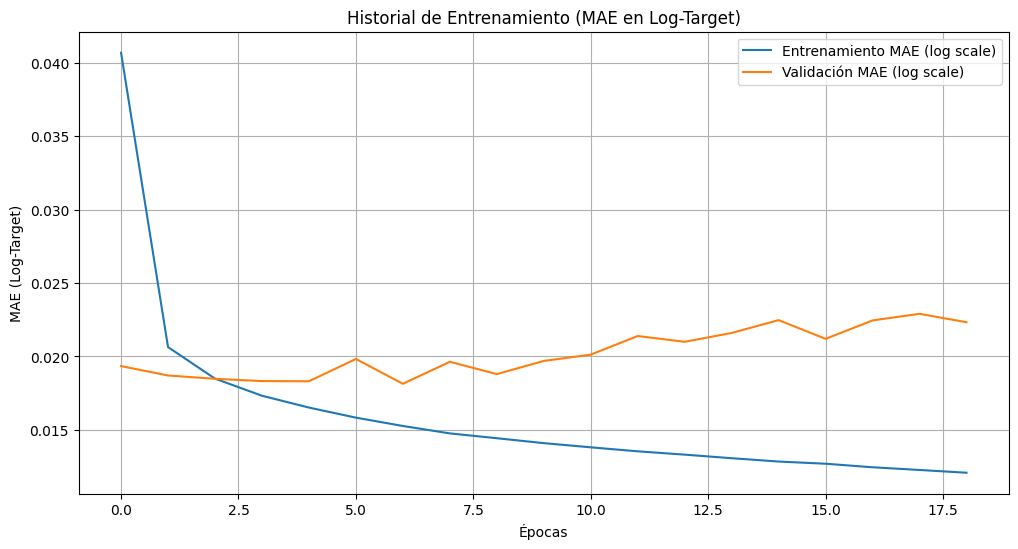


EarlyStopping paró en época: 19
Mejor época (según val_loss): 7
Menor val_loss (MAE en log-target): 0.0181


In [29]:
import matplotlib.pyplot as plt

if 'history' in locals(): # Verifica si la variable history existe
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Entrenamiento MAE (log scale)')
    plt.plot(history.history['val_loss'], label='Validación MAE (log scale)')
    plt.title('Historial de Entrenamiento (MAE en Log-Target)')
    plt.xlabel('Épocas')
    plt.ylabel('MAE (Log-Target)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # También imprime en qué época paró y cuál fue el mejor val_loss
    best_epoch = np.argmin(history.history['val_loss']) + 1
    min_val_loss = np.min(history.history['val_loss'])
    print(f"\nEarlyStopping paró en época: {len(history.history['loss'])}")
    print(f"Mejor época (según val_loss): {best_epoch}")
    print(f"Menor val_loss (MAE en log-target): {min_val_loss:.4f}")
else:
    print("La variable 'history' no fue encontrada. Asegúrate de que la celda de entrenamiento se ejecutó.")


Generando gráficos de evaluación...


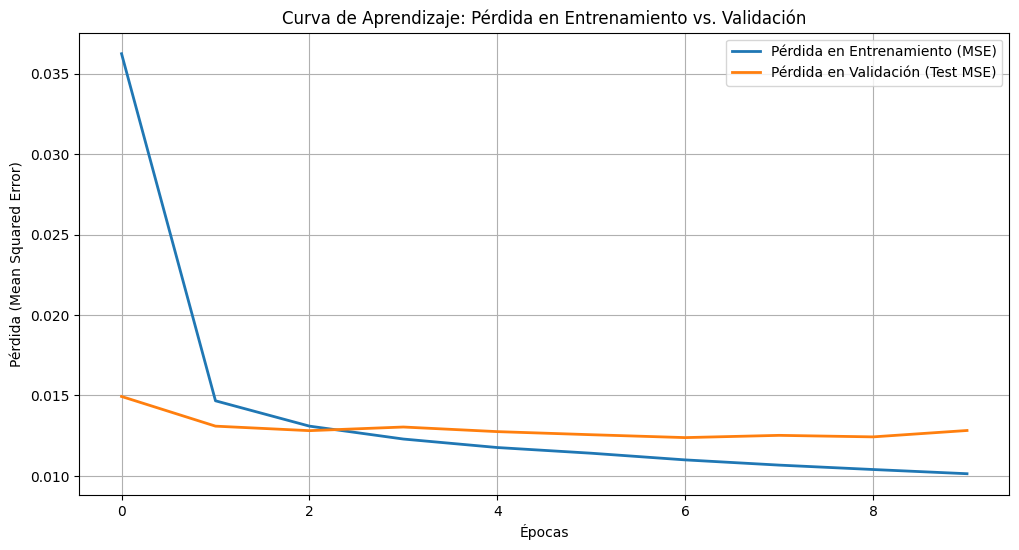

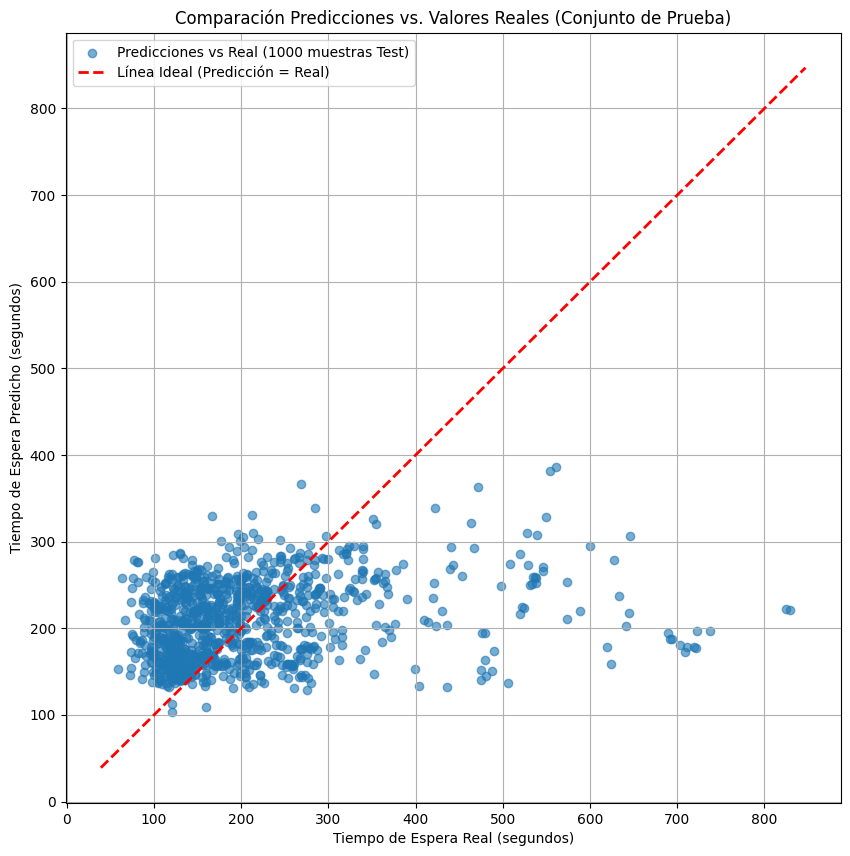

In [33]:
# --- 10. Visualización de Resultados ---

print("\nGenerando gráficos de evaluación...")

# Gráfico de Pérdida (Loss) durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento (MSE)', linewidth=2)
plt.plot(history.history['val_loss'], label='Pérdida en Validación (Test MSE)', linewidth=2)
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Mean Squared Error)')
plt.title('Curva de Aprendizaje: Pérdida en Entrenamiento vs. Validación')
plt.legend()
plt.grid(True)
plt.show() # Esto mostrará el gráfico en el notebook

# Gráfico de Predicciones vs. Valores Reales
# Graficamos una muestra aleatoria de puntos para evitar saturación si hay muchos datos.
plt.figure(figsize=(10, 10))
sample_size = min(1000, len(y_test_inv)) # Tomamos hasta 1000 puntos de muestra
indices = np.random.choice(len(y_test_inv), sample_size, replace=False)

plt.scatter(y_test_inv[indices], y_pred[indices], alpha=0.6, label=f'Predicciones vs Real ({sample_size} muestras Test)')
# Línea ideal y=x para referencia
min_val = min(np.min(y_test_inv), np.min(y_pred))
max_val = max(np.max(y_test_inv), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Línea Ideal (Predicción = Real)')

plt.xlabel('Tiempo de Espera Real (segundos)')
plt.ylabel('Tiempo de Espera Predicho (segundos)')
plt.title('Comparación Predicciones vs. Valores Reales (Conjunto de Prueba)')
plt.legend()
plt.grid(True)
# Ajustamos los límites para una mejor visualización si es necesario
# plt.xlim(0, max(y_test_inv.max(), y_pred.max()) * 1.1)
# plt.ylim(0, max(y_test_inv.max(), y_pred.max()) * 1.1)
plt.show() # Esto mostrará el segundo gráfico

In [43]:
from pyspark.sql import functions as F

# --- 1. Calcular Umbral (Q3 sobre log_takeoff_time) ---
# Asegúrate de que la columna TARGET_COL='log_takeoff_time' existe en df_train
print(f"Calculando Q3 para la columna objetivo: {TARGET_COL}")
try:
    # Usamos approxQuantile para calcular el percentil 75 (Q3)
    # El 0.01 es el error relativo permitido
    q3_value_list = df_train.approxQuantile(TARGET_COL, [0.75], 0.01)
    if not q3_value_list:
        raise ValueError("approxQuantile no devolvió ningún valor.")
    LOG_TAKEOFF_TIME_CUTOFF = q3_value_list[0]
    print(f"Umbral Q3 ({TARGET_COL}): {LOG_TAKEOFF_TIME_CUTOFF:.4f}")

    # --- 2. Dividir df_train ---
    # No necesitamos la lógica de 'first_takeoff_time' del ejemplo LSTM,
    # dividimos directamente por el valor del target logarítmico.
    df_train_low = df_train.filter(col(TARGET_COL) <= LOG_TAKEOFF_TIME_CUTOFF).cache() # Cacheamos para eficiencia
    df_train_high = df_train.filter(col(TARGET_COL) > LOG_TAKEOFF_TIME_CUTOFF).cache()

    # Contar filas
    count_low = df_train_low.count()
    count_high = df_train_high.count()
    print(f"Número de filas en df_train_low (<= {LOG_TAKEOFF_TIME_CUTOFF:.4f}): {count_low}")
    print(f"Número de filas en df_train_high (> {LOG_TAKEOFF_TIME_CUTOFF:.4f}): {count_high}")
    if count_low == 0 or count_high == 0:
        print("ADVERTENCIA: Uno de los dataframes divididos está vacío. Revisa el umbral o los datos.")

except Exception as e:
    print(f"Error al calcular el umbral o dividir los datos: {e}")
    # Detener ejecución o manejar el error como prefieras si esto falla
    raise e # Lanza el error para detener si es crítico

Calculando Q3 para la columna objetivo: log_takeoff_time
Umbral Q3 (log_takeoff_time): 5.4806


Número de filas en df_train_low (<= 5.4806): 92152
Número de filas en df_train_high (> 5.4806): 31581


In [44]:
# Definimos una función para crear nuestro pipeline de preprocesamiento
# Esto evita duplicar el código para los modelos low y high

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

def create_preprocessing_pipeline(numerical_cols, categorical_cols):
    """Crea el pipeline de Spark ML con OHE y StandardScaler selectivo."""

    print("\nDefiniendo estructura del pipeline de preprocesamiento...")
    # Columnas para OHE (ajusta según tu análisis de cardinalidad y si recuperaste 'last_event')
    ohe_cols = ['holding_point', 'runway', 'turbulence_category', 'last_event_turb_cat', 'last_event']
    ohe_cols = [c for c in ohe_cols if c in categorical_cols]
    print(f"Columnas para OneHotEncoding: {ohe_cols}")

    # Columnas solo para Indexer
    indexer_only_cols = [c for c in categorical_cols if c not in ohe_cols]
    print(f"Columnas solo para StringIndexer: {indexer_only_cols}")

    stages = []
    # Etapa 1: Escalar SOLO las numéricas
    num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features_raw", handleInvalid="skip")
    scaler = StandardScaler(inputCol="numerical_features_raw", outputCol="scaled_numerical_features", withStd=True, withMean=True)
    stages.extend([num_assembler, scaler])

    # Etapa 2: Procesar Categóricas
    indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='keep') for col in categorical_cols]
    encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe", dropLast=False) for col in ohe_cols]
    stages.extend(indexers)
    stages.extend(encoders)

    # Etapa 3: Ensamblador Final
    final_assembler_input = ['scaled_numerical_features'] + [f"{c}_ohe" for c in ohe_cols] + [f"{c}_idx" for c in indexer_only_cols]
    final_assembler = VectorAssembler(inputCols=final_assembler_input, outputCol="features", handleInvalid="error")
    stages.append(final_assembler)

    pipeline = Pipeline(stages=stages)
    print("Pipeline definido.")
    return pipeline

# Necesitas tener las listas numerical_cols y categorical_cols FINALES aquí
# (después de añadir cíclicas y quitar originales 'hour', 'weekday', etc.)
# Asumiendo que estas listas existen de la ejecución anterior de la celda 4 combinada:
print(f"Usando {len(numerical_cols)} columnas numéricas y {len(categorical_cols)} categóricas.")
spark_pipeline_structure = create_preprocessing_pipeline(numerical_cols, categorical_cols)

Usando 92 columnas numéricas y 6 categóricas.

Definiendo estructura del pipeline de preprocesamiento...
Columnas para OneHotEncoding: ['holding_point', 'runway', 'turbulence_category', 'last_event_turb_cat']
Columnas solo para StringIndexer: ['operator', 'weekday']
Pipeline definido.


In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler as SklearnMinMaxScaler

print("\n--- Procesando Datos para Modelo LOW ---")

# 1. Ajustar y transformar features LOW
print("Ajustando pipeline Spark en df_train_low...")
pipeline_model_low = spark_pipeline_structure.fit(df_train_low)
print("Transformando df_train_low...")
df_train_low_prepared = pipeline_model_low.transform(df_train_low).select(TARGET_COL, "features")

# 2. Convertir a Pandas/NumPy LOW
print("Convirtiendo a Pandas/NumPy...")
pdf_train_low = df_train_low_prepared.toPandas()
X_train_low_raw = np.stack(pdf_train_low["features"].apply(lambda x: x.toArray()).values)
y_train_low_log_raw = pdf_train_low[TARGET_COL].values
print(f"Shapes Low Raw: X={X_train_low_raw.shape}, y={y_train_low_log_raw.shape}")

# 3. Escalar Target LOW (Log)
print("Escalando target logarítmico (Low)...")
y_scaler_low = SklearnMinMaxScaler()
y_train_low_seq_target = y_scaler_low.fit_transform(y_train_low_log_raw.reshape(-1, 1)).flatten()

# 4. Crear Secuencias LOW
# Asegúrate de que la función create_sequences está definida
print("Creando secuencias (Low)...")
X_train_low_seq, y_train_low_seq = create_sequences(X_train_low_raw, y_train_low_seq_target, TIMESTEPS) # TIMESTEPS debe estar definido (e.g., 10)
print(f"Shapes Low Seq: X={X_train_low_seq.shape}, y={y_train_low_seq.shape}")


--- Procesando Datos para Modelo LOW ---
Ajustando pipeline Spark en df_train_low...


Transformando df_train_low...
Convirtiendo a Pandas/NumPy...


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.

                                                                                

Shapes Low Raw: X=(92152, 131), y=(92152,)
Escalando target logarítmico (Low)...
Creando secuencias (Low)...
Creando secuencias con timesteps=10...
  Secuencias creadas: 92142
Shapes Low Seq: X=(92142, 10, 131), y=(92142,)


In [46]:
print("\n--- Procesando Datos para Modelo HIGH ---")

# 1. Ajustar y transformar features HIGH
print("Ajustando pipeline Spark en df_train_high...")
# ¡IMPORTANTE! Ajustamos un NUEVO pipeline con los datos HIGH
pipeline_model_high = spark_pipeline_structure.fit(df_train_high)
print("Transformando df_train_high...")
df_train_high_prepared = pipeline_model_high.transform(df_train_high).select(TARGET_COL, "features")

# 2. Convertir a Pandas/NumPy HIGH
print("Convirtiendo a Pandas/NumPy...")
pdf_train_high = df_train_high_prepared.toPandas()
X_train_high_raw = np.stack(pdf_train_high["features"].apply(lambda x: x.toArray()).values)
y_train_high_log_raw = pdf_train_high[TARGET_COL].values
print(f"Shapes High Raw: X={X_train_high_raw.shape}, y={y_train_high_log_raw.shape}")

# 3. Escalar Target HIGH (Log)
print("Escalando target logarítmico (High)...")
y_scaler_high = SklearnMinMaxScaler()
y_train_high_seq_target = y_scaler_high.fit_transform(y_train_high_log_raw.reshape(-1, 1)).flatten()

# 4. Crear Secuencias HIGH
print("Creando secuencias (High)...")
X_train_high_seq, y_train_high_seq = create_sequences(X_train_high_raw, y_train_high_seq_target, TIMESTEPS)
print(f"Shapes High Seq: X={X_train_high_seq.shape}, y={y_train_high_seq.shape}")

# Limpieza opcional para liberar memoria
# del pdf_train_low, pdf_train_high, df_train_low_prepared, df_train_high_prepared


--- Procesando Datos para Modelo HIGH ---
Ajustando pipeline Spark en df_train_high...
Transformando df_train_high...
Convirtiendo a Pandas/NumPy...


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.



Shapes High Raw: X=(31581, 128), y=(31581,)
Escalando target logarítmico (High)...
Creando secuencias (High)...
Creando secuencias con timesteps=10...
  Secuencias creadas: 31571
Shapes High Seq: X=(31571, 10, 128), y=(31571,)


In [48]:
# --- Celda 6: Entrenar Modelo LOW (Corregido con Validación) ---

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

print("\n--- Entrenando Modelo LOW ---")

# --- Hiperparámetros (igual que antes) ---
MODEL_UNITS_LOW = 64
DROPOUT_RATE_LOW = 0.25
NUM_HEADS_LOW = 4
input_shape_low = (X_train_low_seq.shape[1], X_train_low_seq.shape[2])
KEY_DIM_LOW = input_shape_low[-1] // NUM_HEADS_LOW if input_shape_low[-1] else 16
L2_REG_LOW = 1e-5
LEARNING_RATE_LOW = 0.0002 # Mantén el LR que estabas probando o ajústalo
EPOCHS_LOW = 20
BATCH_SIZE_LOW = 64
NUM_BLOCKS_LOW = 2

print(f"Input shape Low: {input_shape_low}")

# Reconstruye el modelo por si acaso (asegúrate de que build_transformer_model esté definido)
model_low = build_transformer_model(
    input_shape=input_shape_low,
    units=MODEL_UNITS_LOW,
    dropout_rate=DROPOUT_RATE_LOW,
    num_heads=NUM_HEADS_LOW,
    key_dim=KEY_DIM_LOW,
    l2_reg=L2_REG_LOW,
    learning_rate=LEARNING_RATE_LOW,
    num_blocks=NUM_BLOCKS_LOW
)
# model_low.summary() # Opcional si ya lo viste

# *** CAMBIO AQUÍ: Monitorizar 'val_loss' ***
early_stop_low = EarlyStopping(monitor='val_loss', patience=5, # O aumenta paciencia a 12-15 si quieres
                               restore_best_weights=True, verbose=1, mode='min')
print(f"\nEarlyStopping configurado para monitorizar 'val_loss' con paciencia de {early_stop_low.patience} épocas.")


print("\nIniciando fit para model_low (con validation_split)...")
history_low = model_low.fit(
    X_train_low_seq, y_train_low_seq,
    epochs=EPOCHS_LOW,
    batch_size=BATCH_SIZE_LOW,
    # *** CAMBIO AQUÍ: Añadir validation_split ***
    validation_split=0.15, # Reserva el último 15% de datos de train_low para validar
    callbacks=[early_stop_low],
    verbose=1
)
print("--- Entrenamiento Modelo LOW finalizado ---")

# --- HAZ LO MISMO PARA EL ENTRENAMIENTO DEL MODELO HIGH (Celda 7) ---
# Cambia early_stop_high a monitor='val_loss' y añade validation_split=0.15 a model_high.fit()


--- Entrenando Modelo LOW ---
Input shape Low: (10, 131)
Construyendo modelo SIMPLIFICADO con: units=64, dropout=0.25, heads=4, key_dim=32, blocks=2

EarlyStopping configurado para monitorizar 'val_loss' con paciencia de 5 épocas.

Iniciando fit para model_low (con validation_split)...
Epoch 1/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - loss: 0.1625 - val_loss: 0.1248
Epoch 2/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.1101 - val_loss: 0.1215
Epoch 3/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 0.1016 - val_loss: 0.1187
Epoch 4/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.0934 - val_loss: 0.1364
Epoch 5/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - loss: 0.0876 - val_loss: 0.1360
Epoch 6/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.0821 - val_loss: 0.1384
Epoch 7/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.0786 - val_loss: 0.1338
Epoch 8/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 0.0753 - val_loss:

In [55]:
# --- Celda 7: Entrenar Modelo HIGH (Corregido con Validación) ---
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

print("\n--- Entrenando Modelo HIGH ---")

# --- Hiperparámetros para High ---
MODEL_UNITS_HIGH = 64
DROPOUT_RATE_HIGH = 0.3 # Mantienes el dropout un poco más alto
NUM_HEADS_HIGH = 4
input_shape_high = (X_train_high_seq.shape[1], X_train_high_seq.shape[2])
KEY_DIM_HIGH = input_shape_high[-1] // NUM_HEADS_HIGH if input_shape_high[-1] else 16
L2_REG_HIGH = 1e-5
LEARNING_RATE_HIGH = 0.0001 # Mantienes el LR bajo
EPOCHS_HIGH = 20 # *** AUMENTADO: Dale más épocas para que EarlyStopping actúe ***
BATCH_SIZE_HIGH = 64
NUM_BLOCKS_HIGH = 2

print(f"Input shape High: {input_shape_high}")

# Reconstruye el modelo (asegúrate de que build_transformer_model esté definido)
model_high = build_transformer_model(
    input_shape=input_shape_high,
    units=MODEL_UNITS_HIGH,
    dropout_rate=DROPOUT_RATE_HIGH,
    num_heads=NUM_HEADS_HIGH,
    key_dim=KEY_DIM_HIGH,
    l2_reg=L2_REG_HIGH,
    learning_rate=LEARNING_RATE_HIGH,
    num_blocks=NUM_BLOCKS_HIGH
)
# model_high.summary() # Opcional

# *** CAMBIO AQUÍ: Monitorizar 'val_loss' y ajustar paciencia si quieres ***
early_stop_high = EarlyStopping(monitor='val_loss', patience=5, # O 10, 15...
                                restore_best_weights=True, verbose=1, mode='min')
print(f"\nEarlyStopping configurado para monitorizar 'val_loss' con paciencia de {early_stop_high.patience} épocas.")


print("\nIniciando fit para model_high (con validation_split)...")
history_high = model_high.fit(
    X_train_high_seq, y_train_high_seq,
    epochs=EPOCHS_HIGH, # Usa el valor aumentado
    batch_size=BATCH_SIZE_HIGH,
    # *** CAMBIO AQUÍ: Añadir validation_split ***
    validation_split=0.15, # Reserva el último 15% de train_high para validar
    callbacks=[early_stop_high],
    verbose=1
)
print("--- Entrenamiento Modelo HIGH finalizado ---")


--- Entrenando Modelo HIGH ---
Input shape High: (10, 128)
Construyendo modelo SIMPLIFICADO con: units=64, dropout=0.3, heads=4, key_dim=32, blocks=2

EarlyStopping configurado para monitorizar 'val_loss' con paciencia de 5 épocas.

Iniciando fit para model_high (con validation_split)...
Epoch 1/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.1841 - val_loss: 0.1994
Epoch 2/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.1243 - val_loss: 0.1834
Epoch 3/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.1083 - val_loss: 0.1957
Epoch 4/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0947 - val_loss: 0.1882
Epoch 5/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0871 - val_loss: 0.1900
Epoch 6/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0799 - val_loss: 0.1880
Epoch 7/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0751 - val_loss: 0.1856
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
--- Entrenami

In [56]:
# --- Celda 9: Evaluación Detallada (Modelos Low y High) ---

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyspark.sql.functions import col

print("--- Iniciando Evaluación Detallada ---")

# 1. Dividir df_test según el VALOR REAL del target y el umbral
# -------------------------------------------------------------
print(f"\n1. Dividiendo df_test basado en {TARGET_COL} <= {LOG_TAKEOFF_TIME_CUTOFF:.4f}")
df_test_low_true = df_test.filter(col(TARGET_COL) <= LOG_TAKEOFF_TIME_CUTOFF).cache()
df_test_high_true = df_test.filter(col(TARGET_COL) > LOG_TAKEOFF_TIME_CUTOFF).cache()

count_low_test = df_test_low_true.count()
count_high_test = df_test_high_true.count()
print(f"Número de filas en df_test_low_true: {count_low_test}")
print(f"Número de filas en df_test_high_true: {count_high_test}")

# Variables para almacenar resultados
results = {}

# --- Procesamiento y Evaluación para el Segmento LOW ---
if count_low_test > TIMESTEPS: # Necesitamos suficientes datos para al menos una secuencia
    print("\n--- Procesando y Evaluando Segmento LOW ---")
    # 2. Transformar df_test_low_true con pipeline_model_low
    print("2. Transformando features test-low con pipeline_model_low...")
    df_test_low_prepared = pipeline_model_low.transform(df_test_low_true).select(TARGET_COL, "features")

    # 4. Preparar Datos Keras (Pandas, NumPy, Escalar Target, Secuencias)
    print("4. Preparando datos Keras para test-low...")
    pdf_test_low = df_test_low_prepared.toPandas()
    X_test_low_raw = np.stack(pdf_test_low["features"].apply(lambda x: x.toArray()).values)
    y_test_low_log_raw = pdf_test_low[TARGET_COL].values
    # Escalar target usando el escalador LOW
    y_test_low_log_scaled = y_scaler_low.transform(y_test_low_log_raw.reshape(-1, 1)).flatten()
    # Crear secuencias
    X_test_low_seq, y_test_low_seq = create_sequences(X_test_low_raw, y_test_low_log_scaled, TIMESTEPS)
    print(f"   Shapes Low Seq: X={X_test_low_seq.shape}, y={y_test_low_seq.shape}")

    if X_test_low_seq.shape[0] > 0: # Verificar si se crearon secuencias
        # 6. Predecir con model_low
        print("6. Prediciendo con model_low...")
        y_pred_low_scaled = model_low.predict(X_test_low_seq)

        # 8. Invertir escala y log para Predicciones Low
        print("8. Invirtiendo transformaciones para predicciones low...")
        y_pred_low_log = y_scaler_low.inverse_transform(y_pred_low_scaled).flatten()
        y_pred_low_orig = np.expm1(y_pred_low_log)

        # 9. Invertir escala y log para Reales Low
        print("9. Invirtiendo transformaciones para target real low...")
        y_test_low_log = y_scaler_low.inverse_transform(y_test_low_seq.reshape(-1, 1)).flatten()
        y_test_low_orig = np.expm1(y_test_low_log)

        # 10. Calcular Métricas Low (filtrando inf si es necesario)
        print("10. Calculando métricas para segmento low...")
        finite_mask_low = np.isfinite(y_pred_low_orig) & np.isfinite(y_test_low_orig)
        if not np.all(finite_mask_low):
            print(f"   ADVERTENCIA (Low): Se filtrarán {np.sum(~finite_mask_low)} valores no finitos.")

        results['rmse_low'] = np.sqrt(mean_squared_error(y_test_low_orig[finite_mask_low], y_pred_low_orig[finite_mask_low]))
        results['mae_low'] = mean_absolute_error(y_test_low_orig[finite_mask_low], y_pred_low_orig[finite_mask_low])
        results['n_low'] = len(y_test_low_orig[finite_mask_low]) # Número de muestras válidas

        print(f"   RMSE (Low): {results['rmse_low']:.2f} segundos")
        print(f"   MAE (Low): {results['mae_low']:.2f} segundos")
        print(f"   Muestras (Low): {results['n_low']}")
    else:
        print("   No se pudieron crear secuencias para el segmento low.")
        results['n_low'] = 0
else:
    print(f"\nNo hay suficientes datos ({count_low_test}) en df_test_low_true para crear secuencias con TIMESTEPS={TIMESTEPS}. Saltando evaluación del segmento LOW.")
    results['n_low'] = 0


# --- Procesamiento y Evaluación para el Segmento HIGH ---
if count_high_test > TIMESTEPS: # Necesitamos suficientes datos para al menos una secuencia
    print("\n--- Procesando y Evaluando Segmento HIGH ---")
    # 3. Transformar df_test_high_true con pipeline_model_high
    print("3. Transformando features test-high con pipeline_model_high...")
    df_test_high_prepared = pipeline_model_high.transform(df_test_high_true).select(TARGET_COL, "features")

    # 5. Preparar Datos Keras (Pandas, NumPy, Escalar Target, Secuencias)
    print("5. Preparando datos Keras para test-high...")
    pdf_test_high = df_test_high_prepared.toPandas()
    X_test_high_raw = np.stack(pdf_test_high["features"].apply(lambda x: x.toArray()).values)
    y_test_high_log_raw = pdf_test_high[TARGET_COL].values
    # Escalar target usando el escalador HIGH
    y_test_high_log_scaled = y_scaler_high.transform(y_test_high_log_raw.reshape(-1, 1)).flatten()
    # Crear secuencias
    X_test_high_seq, y_test_high_seq = create_sequences(X_test_high_raw, y_test_high_log_scaled, TIMESTEPS)
    print(f"   Shapes High Seq: X={X_test_high_seq.shape}, y={y_test_high_seq.shape}")

    if X_test_high_seq.shape[0] > 0: # Verificar si se crearon secuencias
        # 7. Predecir con model_high
        print("7. Prediciendo con model_high...")
        y_pred_high_scaled = model_high.predict(X_test_high_seq)

        # 11a. Invertir escala y log para Predicciones High
        print("11a. Invirtiendo transformaciones para predicciones high...")
        y_pred_high_log = y_scaler_high.inverse_transform(y_pred_high_scaled).flatten()
        y_pred_high_orig = np.expm1(y_pred_high_log)

        # 11b. Invertir escala y log para Reales High
        print("11b. Invirtiendo transformaciones para target real high...")
        y_test_high_log = y_scaler_high.inverse_transform(y_test_high_seq.reshape(-1, 1)).flatten()
        y_test_high_orig = np.expm1(y_test_high_log)

        # 11c. Calcular Métricas High (filtrando inf si es necesario)
        print("11c. Calculando métricas para segmento high...")
        finite_mask_high = np.isfinite(y_pred_high_orig) & np.isfinite(y_test_high_orig)
        if not np.all(finite_mask_high):
            print(f"   ADVERTENCIA (High): Se filtrarán {np.sum(~finite_mask_high)} valores no finitos.")

        results['rmse_high'] = np.sqrt(mean_squared_error(y_test_high_orig[finite_mask_high], y_pred_high_orig[finite_mask_high]))
        results['mae_high'] = mean_absolute_error(y_test_high_orig[finite_mask_high], y_pred_high_orig[finite_mask_high])
        results['n_high'] = len(y_test_high_orig[finite_mask_high]) # Número de muestras válidas

        print(f"   RMSE (High): {results['rmse_high']:.2f} segundos")
        print(f"   MAE (High): {results['mae_high']:.2f} segundos")
        print(f"   Muestras (High): {results['n_high']}")
    else:
        print("   No se pudieron crear secuencias para el segmento high.")
        results['n_high'] = 0
else:
    print(f"\nNo hay suficientes datos ({count_high_test}) en df_test_high_true para crear secuencias con TIMESTEPS={TIMESTEPS}. Saltando evaluación del segmento HIGH.")
    results['n_high'] = 0


# --- 12. Calcular Métricas Combinadas (Promedio Ponderado) ---
# --------------------------------------------------------------
print("\n--- Calculando Métricas Combinadas ---")
n_low = results.get('n_low', 0)
n_high = results.get('n_high', 0)
n_total = n_low + n_high

if n_total > 0:
    # MAE Combinado
    mae_low = results.get('mae_low', 0)
    mae_high = results.get('mae_high', 0)
    combined_mae = (mae_low * n_low + mae_high * n_high) / n_total

    # RMSE Combinado (promedio ponderado de errores CUADRADOS)
    rmse_low_sq = results.get('rmse_low', 0)**2
    rmse_high_sq = results.get('rmse_high', 0)**2
    combined_rmse = np.sqrt((rmse_low_sq * n_low + rmse_high_sq * n_high) / n_total)

    print(f"\n--- Métricas Combinadas (Ponderadas por #muestras) ---")
    print(f"  RMSE Combinado: {combined_rmse:.2f} segundos")
    print(f"  MAE Combinado:  {combined_mae:.2f} segundos")
    print(f"  Muestras Totales Evaluadas: {n_total} (Low: {n_low}, High: {n_high})")

    # Comparar con un posible modelo único anterior (si mae_test existe de una ejecución previa)
    if 'mae_test' in locals():
        print(f"\nComparación MAE Combinado vs MAE Modelo Único anterior:")
        print(f"  MAE Combinado: {combined_mae:.2f}")
        print(f"  MAE Único:     {mae_test:.2f}")
        print(f"  Diferencia:    {mae_test - combined_mae:.2f} (positivo si el combinado es mejor)")

else:
    print("\nNo se evaluaron muestras en ninguno de los segmentos. No se pueden calcular métricas combinadas.")

print("\n--- Evaluación Detallada Finalizada ---")

--- Iniciando Evaluación Detallada ---

1. Dividiendo df_test basado en log_takeoff_time <= 5.4806


25/04/27 23:37:18 WARN CacheManager: Asked to cache already cached data.
25/04/27 23:37:18 WARN CacheManager: Asked to cache already cached data.


Número de filas en df_test_low_true: 20526
Número de filas en df_test_high_true: 7265

--- Procesando y Evaluando Segmento LOW ---
2. Transformando features test-low con pipeline_model_low...
4. Preparando datos Keras para test-low...


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.



Creando secuencias con timesteps=10...
  Secuencias creadas: 20516
   Shapes Low Seq: X=(20516, 10, 131), y=(20516,)
6. Prediciendo con model_low...
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
8. Invirtiendo transformaciones para predicciones low...
9. Invirtiendo transformaciones para target real low...
10. Calculando métricas para segmento low...
   RMSE (Low): 43.13 segundos
   MAE (Low): 35.02 segundos
   Muestras (Low): 20516

--- Procesando y Evaluando Segmento HIGH ---
3. Transformando features test-high con pipeline_model_high...
5. Preparando datos Keras para test-high...


/home/bryan/PD2/despegueHUB/pruebas/.venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.



Creando secuencias con timesteps=10...
  Secuencias creadas: 7255
   Shapes High Seq: X=(7255, 10, 128), y=(7255,)
7. Prediciendo con model_high...
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
11a. Invirtiendo transformaciones para predicciones high...
11b. Invirtiendo transformaciones para target real high...
11c. Calculando métricas para segmento high...
   RMSE (High): 139.74 segundos
   MAE (High): 84.17 segundos
   Muestras (High): 7255

--- Calculando Métricas Combinadas ---

--- Métricas Combinadas (Ponderadas por #muestras) ---
  RMSE Combinado: 80.47 segundos
  MAE Combinado:  47.86 segundos
  Muestras Totales Evaluadas: 27771 (Low: 20516, High: 7255)

Comparación MAE Combinado vs MAE Modelo Único anterior:
  MAE Combinado: 47.86
  MAE Único:     67.75
  Diferencia:    19.90 (positivo si el combinado es mejor)

--- Evaluación Detallada Finalizada ---


In [34]:
# --- 11. Detener Spark Session ---
# Es una buena práctica detener la sesión de Spark cuando hemos terminado.
print("\nDeteniendo Spark Session...")
spark.stop()
print("Spark Session detenida. Proceso completado.")


Deteniendo Spark Session...
Spark Session detenida. Proceso completado.


In [ ]:
# --- Celda 9: Evaluación Detallada (CORREGIDA v3 - con row_id y columnas originales desde el inicio) ---

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyspark.sql.functions import col, monotonically_increasing_id
import warnings # Importar warnings
import traceback # Importar traceback

# Suprimir warnings de PyArrow si son molestos
warnings.filterwarnings("ignore", message="toPandas attempted Arrow optimization*")

print("--- Iniciando Evaluación Detallada (con Row ID) ---")

# --- Preparación Inicial ---
# Asunciones: df_test, LOG_TAKEOFF_TIME_CUTOFF, pipeline_model_low, pipeline_model_high,
#             y_scaler_low, y_scaler_high, model_low, model_high, TARGET_COL, TIMESTEPS, create_sequences existen

try:
    # 1. Definir columnas originales NECESARIAS para Evaluator ANTES de cualquier conversión
    # ---------------------------------------------------------------------------------
    original_cols_for_evaluator = ['runway', 'holding_point', 'weekday', 'hour'] # <-- INCLUYE TODAS LAS NECESARIAS AQUÍ
    print(f"Columnas originales requeridas por Evaluator: {original_cols_for_evaluator}")

    # 2. Añadir ID Único y seleccionar columnas necesarias ANTES de toPandas
    # --------------------------------------------------------------------
    print("\n1. Añadiendo row_id y seleccionando columnas necesarias de df_test...")
    df_test_with_id = df_test.withColumn("row_id", monotonically_increasing_id())

    # Construir lista final de columnas a seleccionar desde Spark
    cols_to_select = ['row_id', TARGET_COL] # Siempre necesitamos ID y Target (log)
    if 'takeoff_time' in df_test_with_id.columns: # Incluir target original si existe
        cols_to_select.append('takeoff_time')
    # Añadir columnas para el Evaluator, asegurándose de que existen en el DF Spark
    valid_original_cols = [c for c in original_cols_for_evaluator if c in df_test_with_id.columns]
    print(f"   Columnas originales válidas encontradas: {valid_original_cols}")
    cols_to_select.extend(valid_original_cols)
    # Quitar duplicados
    cols_to_select = list(dict.fromkeys(cols_to_select))
    print(f"   Columnas finales a seleccionar de Spark: {cols_to_select}")

    # Convertir a Pandas SOLO con las columnas necesarias y establecer índice
    df_test_pandas_full = df_test_with_id.select(cols_to_select).toPandas().set_index('row_id')
    print(f"   df_test_pandas_full creado con índice 'row_id', shape: {df_test_pandas_full.shape}")
    print(f"   Columnas en df_test_pandas_full: {df_test_pandas_full.columns.tolist()}")


    # 3. Dividir df_test_with_id (Spark DF) según el VALOR REAL del target
    # -----------------------------------------------------------------
    print(f"\n2. Dividiendo df_test basado en {TARGET_COL} <= {LOG_TAKEOFF_TIME_CUTOFF:.4f}")
    # Re-usa df_test_with_id que ya tiene la columna row_id
    df_test_low_true_id = df_test_with_id.filter(col(TARGET_COL) <= LOG_TAKEOFF_TIME_CUTOFF).cache()
    df_test_high_true_id = df_test_with_id.filter(col(TARGET_COL) > LOG_TAKEOFF_TIME_CUTOFF).cache()
    count_low_test = df_test_low_true_id.count()
    count_high_test = df_test_high_true_id.count()
    print(f"   Filas en df_test_low_true_id: {count_low_test}")
    print(f"   Filas en df_test_high_true_id: {count_high_test}")

    # Variables para almacenar resultados
    results = {}
    y_pred_low_series = pd.Series(dtype=float)
    y_true_low_series = pd.Series(dtype=float)
    y_pred_high_series = pd.Series(dtype=float)
    y_true_high_series = pd.Series(dtype=float)


    # --- Procesamiento y Evaluación para el Segmento LOW (sin cambios internos aquí) ---
    # ---------------------------------------------------------------------------------
    if count_low_test > TIMESTEPS:
        print("\n--- Procesando y Evaluando Segmento LOW ---")
        df_test_low_prepared = pipeline_model_low.transform(df_test_low_true_id).select('row_id', TARGET_COL, "features").cache()
        pdf_test_low = df_test_low_prepared.toPandas().set_index('row_id')
        X_test_low_raw = np.stack(pdf_test_low["features"].apply(lambda x: x.toArray()).values)
        y_test_low_log_raw = pdf_test_low[TARGET_COL].values
        y_test_low_log_scaled = y_scaler_low.transform(y_test_low_log_raw.reshape(-1, 1)).flatten()
        X_test_low_seq, y_test_low_seq = create_sequences(X_test_low_raw, y_test_low_log_scaled, TIMESTEPS)
        index_low_seq = pdf_test_low.index[TIMESTEPS:]
        print(f"   Índices (row_id) para secuencias low: {len(index_low_seq)}")
        if X_test_low_seq.shape[0] > 0:
            y_pred_low_scaled = model_low.predict(X_test_low_seq)
            y_pred_low_log = y_scaler_low.inverse_transform(y_pred_low_scaled).flatten()
            y_pred_low_orig = np.expm1(y_pred_low_log)
            y_test_low_log = y_scaler_low.inverse_transform(y_test_low_seq.reshape(-1, 1)).flatten()
            y_test_low_orig = np.expm1(y_test_low_log)
            y_pred_low_series = pd.Series(y_pred_low_orig, index=index_low_seq)
            y_true_low_series = pd.Series(y_test_low_orig, index=index_low_seq)
            finite_mask_low = np.isfinite(y_pred_low_orig) & np.isfinite(y_test_low_orig)
            results['rmse_low'] = np.sqrt(mean_squared_error(y_test_low_orig[finite_mask_low], y_pred_low_orig[finite_mask_low]))
            results['mae_low'] = mean_absolute_error(y_test_low_orig[finite_mask_low], y_pred_low_orig[finite_mask_low])
            results['n_low'] = np.sum(finite_mask_low)
            print(f"   RMSE (Low): {results['rmse_low']:.2f} s | MAE (Low): {results['mae_low']:.2f} s | Muestras: {results['n_low']}")
        else: results['n_low'] = 0
        df_test_low_prepared.unpersist()
    else: results['n_low'] = 0


    # --- Procesamiento y Evaluación para el Segmento HIGH (sin cambios internos aquí) ---
    # ----------------------------------------------------------------------------------
    if count_high_test > TIMESTEPS:
        print("\n--- Procesando y Evaluando Segmento HIGH ---")
        df_test_high_prepared = pipeline_model_high.transform(df_test_high_true_id).select('row_id', TARGET_COL, "features").cache()
        pdf_test_high = df_test_high_prepared.toPandas().set_index('row_id')
        X_test_high_raw = np.stack(pdf_test_high["features"].apply(lambda x: x.toArray()).values)
        y_test_high_log_raw = pdf_test_high[TARGET_COL].values
        y_test_high_log_scaled = y_scaler_high.transform(y_test_high_log_raw.reshape(-1, 1)).flatten()
        X_test_high_seq, y_test_high_seq = create_sequences(X_test_high_raw, y_test_high_log_scaled, TIMESTEPS)
        index_high_seq = pdf_test_high.index[TIMESTEPS:]
        print(f"   Índices (row_id) para secuencias high: {len(index_high_seq)}")
        if X_test_high_seq.shape[0] > 0:
            y_pred_high_scaled = model_high.predict(X_test_high_seq)
            y_pred_high_log = y_scaler_high.inverse_transform(y_pred_high_scaled).flatten()
            y_pred_high_orig = np.expm1(y_pred_high_log)
            y_test_high_log = y_scaler_high.inverse_transform(y_test_high_seq.reshape(-1, 1)).flatten()
            y_test_high_orig = np.expm1(y_test_high_log)
            y_pred_high_series = pd.Series(y_pred_high_orig, index=index_high_seq)
            y_true_high_series = pd.Series(y_test_high_orig, index=index_high_seq)
            finite_mask_high = np.isfinite(y_pred_high_orig) & np.isfinite(y_test_high_orig)
            results['rmse_high'] = np.sqrt(mean_squared_error(y_test_high_orig[finite_mask_high], y_pred_high_orig[finite_mask_high]))
            results['mae_high'] = mean_absolute_error(y_test_high_orig[finite_mask_high], y_pred_high_orig[finite_mask_high])
            results['n_high'] = np.sum(finite_mask_high)
            print(f"   RMSE (High): {results['rmse_high']:.2f} s | MAE (High): {results['mae_high']:.2f} s | Muestras: {results['n_high']}")
        else: results['n_high'] = 0
        df_test_high_prepared.unpersist()
    else: results['n_high'] = 0


    # --- Combinar Resultados y Evaluar ---
    # -------------------------------------
    print("\n--- Combinando Resultados para Evaluator ---")
    n_low = results.get('n_low', 0)
    n_high = results.get('n_high', 0)
    n_total = n_low + n_high

    if n_total > 0:
        # Concatenar las Series (los índices row_id aseguran la alineación correcta)
        y_pred_combined_series = pd.concat([y_pred_low_series, y_pred_high_series]).sort_index()
        y_true_combined_series = pd.concat([y_true_low_series, y_true_high_series]).sort_index()

        # Crear el DataFrame final usando las series combinadas y el nombre de columna correcto
        df_eval_final = pd.DataFrame({
            'takeoff_time': y_true_combined_series, # Nombre esperado por Evaluator
            'prediction': y_pred_combined_series
        })

        # Unir las columnas originales necesarias desde df_test_pandas_full usando el índice row_id
        print(f"Uniendo columnas originales: {valid_original_cols}") # Usa la lista validada
        if valid_original_cols: # Solo une si hay columnas válidas que unir
            df_eval_final = df_eval_final.join(df_test_pandas_full[valid_original_cols])

        print(f"DataFrame final para evaluación creado, shape: {df_eval_final.shape}")
        print(f"Columnas: {df_eval_final.columns.tolist()}") # Verifica que 'weekday' y 'hour' están
        if df_eval_final.isna().any().any():
            print(f"ADVERTENCIA: NaNs encontrados en df_eval_final. Columnas: {df_eval_final.columns[df_eval_final.isna().any()].tolist()}")
        else:
            print("DataFrame final sin NaNs detectados.")

        # Calcular métricas combinadas manualmente (para verificar)
        mae_low_val = results.get('mae_low', 0)
        mae_high_val = results.get('mae_high', 0)
        combined_mae_manual = (mae_low_val * n_low + mae_high_val * n_high) / n_total
        rmse_low_sq = results.get('rmse_low', 0)**2
        rmse_high_sq = results.get('rmse_high', 0)**2
        combined_rmse_manual = np.sqrt((rmse_low_sq * n_low + rmse_high_sq * n_high) / n_total)
        print(f"\nMAE Combinado (Manual): {combined_mae_manual:.2f}")
        print(f"RMSE Combinado (Manual): {combined_rmse_manual:.2f}")


        # Instanciar y usar el Evaluator
        print("\nInicializando Evaluator...")
        # Pasamos el df_eval_final que AHORA SÍ tiene todas las columnas necesarias
        ev = Evaluator(df_eval_final, "Transformer (Split Low/High)", combined_mae_manual, combined_rmse_manual)
        print("Generando reporte...")
        report = ev.getReport()
        print("Reporte del Evaluator:")
        print(report) # Ahora el MAE global aquí debería coincidir con combined_mae_manual
        print("Generando evaluación visual...")
        ev.visualEvaluation() # Ahora debería funcionar sin KeyError
        print("\n--- Evaluación con Evaluator Finalizada ---")

    else:
        print("\nNo se evaluaron muestras en ninguno de los segmentos. No se puede instanciar Evaluator.")

except Exception as e:
    print(f"\nError durante la preparación/evaluación combinada: {e}")
    traceback.print_exc()

finally:
    # Limpiar caché de Spark al final
    df_test_low_true_id.unpersist()
    df_test_high_true_id.unpersist()
    print("\nCaché de Spark liberado.")